# 糸球体分類 nph腎症

# import

In [1]:
import os
import os.path as osp
import math
import glob
import random
import json
from tqdm import tqdm
import torch
import torch.utils.data as data
import torchvision
from torchvision import transforms, datasets
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import albumentations
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 乱数のシードを設定
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 前処理

In [3]:
#albumentationsによる前処理の指定
albu_transforms = albumentations.Compose([
                   albumentations.HorizontalFlip(),
                   albumentations.VerticalFlip(),#組み合わせすぎても意味ない？
                   albumentations.RandomRotate90(),
])

def albumentations_transform(image, transform=albu_transforms):
    image_np = np.array(image)
    augmented = transform(image=image_np)
    image = Image.fromarray(augmented["image"])
    return image

In [4]:
# 入力画像の前処理をするクラス
# 辞書型で訓練時と推論時の処理を分ける


class ImageTransform():
    """
    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train":transforms.Compose([
#                  transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),#糸球体の全体が見えなくなっている
                 transforms.Resize((resize,resize)),
                 transforms.Lambda(albumentations_transform),
                 transforms.ToTensor(),
                 transforms.RandomErasing(),
                 transforms.Normalize(mean,std),#標準化により組織画像の特徴が失われている、データセットの値で標準化する？
             ]),
            "val":transforms.Compose([
                 transforms.Resize((resize,resize)),
#                  transforms.Resize(resize),  # リサイズ
#                  transforms.CenterCrop(resize),
                 transforms.ToTensor(),
                 transforms.Normalize(mean,std),
             ]),
         }


    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

RGB
(640, 578)


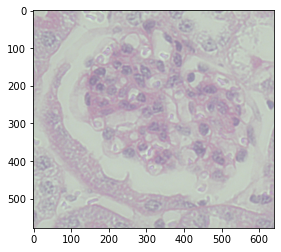

<built-in method mode of Tensor object at 0x000001FA5EAE5E00>
torch.Size([3, 224, 224])


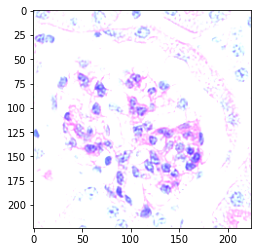

In [5]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる(augmentationの内容がエポックごとに変わる)

rootpath = "./yukisan"
# 1. 画像読み込み
image_file_path = rootpath + "/0/seq0.png"


# channel数が4(RGBA Aは透過度)になっているから3に直す
img = Image.open(image_file_path).convert('RGB')
print(img.mode)#RGBになっているか確認
print(img.size)

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])
print(img_transformed.mode)
print(img_transformed.size())#前処理後の画像サイズを確認

# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

# Dataset, Dataloader の定義

train_test_splitによる訓練セット、テストセットのパスリストの作成

In [6]:
target_path = "./yukisan/*/seq*.png"
path_list = []#すべての画像データのパスを格納するリスト
for path in glob.glob(target_path):
    path_list.append(path)
    
len(path_list)

249

In [7]:
label_list = []#すべての画像のラベルを格納するリスト
for path in glob.glob(target_path):
    label = path[10]
    label_list.append(label)

len(label_list)    

249

In [8]:
from sklearn.model_selection import train_test_split

test_size=0.3
train_list, val_list, train_label, val_label = train_test_split(
    path_list, label_list, test_size=test_size, stratify=label_list, random_state=42)#labelはstratifyで指定するために入力 class GlomerulusDatasetには渡さない
print("訓練セットのデータ数 {}".format(len(train_list)))
print("テストセットのデータ数 {}".format(len(val_list)))
print("訓練セットにおけるラベル 2 の割合 {:.2f}%".format(train_label.count("2")/len(train_label)))
print("テストセットにおけるラベル 2 の割合 {:.2f}%".format(val_label.count("2")/len(val_label)))

訓練セットのデータ数 174
テストセットのデータ数 75
訓練セットにおけるラベル 2 の割合 0.18%
テストセットにおけるラベル 2 の割合 0.19%


In [11]:
# 糸球体画像のDatasetを作成する

class GlomerulusDataset(data.Dataset):
    """
    糸球体画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or testの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
#         img = Image.open(img_path)  # [高さ][幅][色RGB]
        img = Image.open(img_path).convert('RGB')

        # 画像の前処理を実施
        img_transformed = self.transform(img, self.phase)  # torch.Size([3, 224, 224])、クラスを呼び出すことで__call__メソッドが発動

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = str(img_path[10])
        elif self.phase == "val":
            label = str(img_path[10])
        # labelを付け直す(直接整数型にすると5分類にできない,今は7分類なので直接int()していい)   
        if label == "0":
            label = 0
            
        elif label == "1":
            label = 1
            
        elif label == "2":
            label = 2
            
        elif label == "3":
            label = 3
            
        elif label == "4":
            label = 4
            
        elif label == "5":
            label = 5
            
        elif label == "6":
            label = 6

        return img_transformed, label, img_path#学習後、画像を確認するためにimg_pathも抽出
    


# 実行
train_dataset = GlomerulusDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = GlomerulusDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 70
print(train_dataset.__getitem__(index)[0].size())#サイズ確認
print(train_dataset.__getitem__(index)[1])#ラベル確認
print(train_dataset.__getitem__(index)[2])#パスの確認

#以下は固有なラベルの種類を確認するコード
# train_label_list = []
# for i in range(117):#train_datasetは117個
#     train_label_list.append(train_dataset.__getitem__(i)[1])
    

# print(set(train_label_list))

# val_label_list = []
# for i in range(70):#val_datasetは49個
#     val_label_list.append(val_dataset.__getitem__(i)[1])
    

# print(set(val_label_list))




torch.Size([3, 224, 224])
2
./yukisan\2\seq193.png


In [12]:
def im_collate_fn(batch):
    """
    Datasetから画像のpathも抽出できるようにするコード
    
    """
    imgs = []
    targets = []
    paths = []
   
    
    for sample in batch:
        imgs.append(sample[0])
        targets.append(sample[1])
        paths.append(sample[2])
        
    imgs = torch.stack(imgs, dim=0)#にバッチ数の次元を追加
    targets = torch.tensor(targets, dtype=torch.int64)#このタイミングでラベルをリストごとテンソルに直す
    
    return imgs, targets, paths

In [13]:
# ミニバッチのサイズを指定
batch_size = 5

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=im_collate_fn)#引数collate_fnによりカスタマイズしたreturn1を得る

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last = False, collate_fn=im_collate_fn)

#辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
# batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
# inputs, labels = next(
#     batch_iterator)  # 1番目の要素を取り出す
# print(inputs.size())
# print(labels)

for images, labels, pathes in train_dataloader:
    print("batch images size: {}".format(images.size()))
    print("image size: {}".format(images[0].size()))
    print("batch labels size: {}".format(labels.size()))
    print(labels)
    print(pathes[0])
    break


batch images size: torch.Size([5, 3, 224, 224])
image size: torch.Size([3, 224, 224])
batch labels size: torch.Size([5])
tensor([5, 2, 2, 4, 2])
./yukisan\5\seq98.png


# モデルの調整と損失関数、最適化関数の定義

In [14]:
def get_model(target_num, isPretrained=False):
    """
    modelを得る関数
    Parameters
    -------------
    target_num : int
        ラベルの数
    isPretrained : bool
        転移学習を用いるかどうか
        
    Returns
    -------------
    model_ft
    """
    model_ft = models.resnet101(pretrained=isPretrained)
    model_ft.fc = nn.Linear(2048, target_num)#resnet50の時
#     model_ft.fc = nn.Linear(512, target_num) #resnet18の時
    return model_ft

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = get_model(target_num=7, isPretrained=True).to(device)
print(net)
print("Device: {}".format(device))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
#パラメーターを6つに分類しそれぞれで学習率を変えるためにパラメーターをリストに格納
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []
params_to_update_4 = []
params_to_update_5= []
params_to_update_6 = []

update_param_names_1 = [
"conv1.weight", "bn1.weight", "bn1.bias"
]
update_param_names_2 =[
"layer1.0.conv1.weight",
"layer1.0.bn1.weight",
"layer1.0.bn1.bias", 
"layer1.0.conv2.weight", 
"layer1.0.bn2.weight",
"layer1.0.bn2.bias",
"layer1.0.conv3.weight",
"layer1.0.bn3.weight",
"layer1.0.bn3.bias",
"layer1.0.downsample.0.weight",
"layer1.0.downsample.1.weight",
"layer1.0.downsample.1.bias",
"layer1.1.conv1.weight",
"layer1.1.bn1.weight",
"layer1.1.bn1.bias",
"layer1.1.conv2.weight",
"layer1.1.bn2.weight",
"layer1.1.bn2.bias",
"layer1.1.conv3.weight",
"layer1.1.bn3.weight",
"layer1.1.bn3.bias",
"layer1.2.conv1.weight",
"layer1.2.bn1.weight",
"layer1.2.bn1.bias",
"layer1.2.conv2.weight",
"layer1.2.bn2.weight",
"layer1.2.bn2.bias",
"layer1.2.conv3.weight",
"layer1.2.bn3.weight",
"layer1.2.bn3.bias"
]
update_param_names_3 =[
"layer2.0.conv1.weight",
"layer2.0.bn1.weight",
"layer2.0.bn1.bias",
"layer2.0.conv2.weight",
"layer2.0.bn2.weight",
"layer2.0.bn2.bias",
"layer2.0.conv3.weight",
"layer2.0.bn3.weight",
"layer2.0.bn3.bias",
"layer2.0.downsample.0.weight",
"layer2.0.downsample.1.weight",
"layer2.0.downsample.1.bias",
"layer2.1.conv1.weight",
"layer2.1.bn1.weight",
"layer2.1.bn1.bias",
"layer2.1.conv2.weight",
"layer2.1.bn2.weight",
"layer2.1.bn2.bias",
"layer2.1.conv3.weight",
"layer2.1.bn3.weight",
"layer2.1.bn3.bias",
"layer2.2.conv1.weight",
"layer2.2.bn1.weight",
"layer2.2.bn1.bias",
"layer2.2.conv2.weight",
"layer2.2.bn2.weight",
"layer2.2.bn2.bias",
"layer2.2.conv3.weight",
"layer2.2.bn3.weight",
"layer2.2.bn3.bias",
"layer2.3.conv1.weight",
"layer2.3.bn1.weight",
"layer2.3.bn1.bias",
"layer2.3.conv2.weight",
"layer2.3.bn2.weight",
"layer2.3.bn2.bias",
"layer2.3.conv3.weight",
"layer2.3.bn3.weight",
"layer2.3.bn3.bias"
]
update_param_names_4 =[
"layer3.0.conv1.weight",
"layer3.0.bn1.weight",
"layer3.0.bn1.bias",
"layer3.0.conv2.weight",
"layer3.0.bn2.weight",
"layer3.0.bn2.bias",
"layer3.0.conv3.weight",
"layer3.0.bn3.weight",
"layer3.0.bn3.bias",
"layer3.0.downsample.0.weight",
"layer3.0.downsample.1.weight",
"layer3.0.downsample.1.bias",
"layer3.1.conv1.weight",
"layer3.1.bn1.weight",
"layer3.1.bn1.bias",
"layer3.1.conv2.weight",
"layer3.1.bn2.weight",
"layer3.1.bn2.bias",
"layer3.1.conv3.weight",
"layer3.1.bn3.weight",
"layer3.1.bn3.bias",
"layer3.2.conv1.weight",
"layer3.2.bn1.weight",
"layer3.2.bn1.bias",
"layer3.2.conv2.weight",
"layer3.2.bn2.weight",
"layer3.2.bn2.bias",
"layer3.2.conv3.weight",
"layer3.2.bn3.weight",
"layer3.2.bn3.bias",
"layer3.3.conv1.weight",
"layer3.3.bn1.weight",
"layer3.3.bn1.bias",
"layer3.3.conv2.weight",
"layer3.3.bn2.weight",
"layer3.3.bn2.bias",
"layer3.3.conv3.weight",
"layer3.3.bn3.weight",
"layer3.3.bn3.bias",
"layer3.4.conv1.weight",
"layer3.4.bn1.weight",
"layer3.4.bn1.bias",
"layer3.4.conv2.weight",
"layer3.4.bn2.weight",
"layer3.4.bn2.bias",
"layer3.4.conv3.weight",
"layer3.4.bn3.weight",
"layer3.4.bn3.bias",
"layer3.5.conv1.weight",
"layer3.5.bn1.weight",
"layer3.5.bn1.bias",
"layer3.5.conv2.weight",
"layer3.5.bn2.weight",
"layer3.5.bn2.bias",
"layer3.5.conv3.weight",
"layer3.5.bn3.weight",
"layer3.5.bn3.biasfc.weight", 
]
update_param_names_5 =[
"layer4.0.conv1.weight",
"layer4.0.bn1.weight",
"layer4.0.bn1.bias",
"layer4.0.conv2.weight",
"layer4.0.bn2.weight",
"layer4.0.bn2.bias",
"layer4.0.conv3.weight",
"layer4.0.bn3.weight",
"layer4.0.bn3.bias",
"layer4.0.downsample.0.weight",
"layer4.0.downsample.1.weight",
"layer4.0.downsample.1.bias",
"layer4.1.conv1.weight",
"layer4.1.bn1.weight",
"layer4.1.bn1.bias",
"layer4.1.conv2.weight",
"layer4.1.bn2.weight",
"layer4.1.bn2.bias",
"layer4.1.conv3.weight",
"layer4.1.bn3.weight",
"layer4.1.bn3.bias",
"layer4.2.conv1.weight",
"layer4.2.bn1.weight",
"layer4.2.bn1.bias",
"layer4.2.conv2.weight",
"layer4.2.bn2.weight",
"layer4.2.bn2.bias",
"layer4.2.conv3.weight",
"layer4.2.bn3.weight",
"layer4.2.bn3.bias"
]


update_param_names_6 =["fc.weight", "fc.bias"]


# パラメータごとに各リストに格納する
for name, param in net.named_parameters():
    if name in update_param_names_1:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)
        
    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)
        
    elif name in update_param_names_4:
        param.requires_grad = True
        params_to_update_4.append(param)
        print("params_to_update_4に格納：", name)
        
    elif name in update_param_names_5:
        param.requires_grad = True
        params_to_update_5.append(param)
        print("params_to_update_5に格納：", name)
        
    elif name in update_param_names_6:
        param.requires_grad = True
        params_to_update_6.append(param)
        print("params_to_update_6に格納：", name)


    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)

params_to_update_1に格納： conv1.weight
params_to_update_1に格納： bn1.weight
params_to_update_1に格納： bn1.bias
params_to_update_2に格納： layer1.0.conv1.weight
params_to_update_2に格納： layer1.0.bn1.weight
params_to_update_2に格納： layer1.0.bn1.bias
params_to_update_2に格納： layer1.0.conv2.weight
params_to_update_2に格納： layer1.0.bn2.weight
params_to_update_2に格納： layer1.0.bn2.bias
params_to_update_2に格納： layer1.0.conv3.weight
params_to_update_2に格納： layer1.0.bn3.weight
params_to_update_2に格納： layer1.0.bn3.bias
params_to_update_2に格納： layer1.0.downsample.0.weight
params_to_update_2に格納： layer1.0.downsample.1.weight
params_to_update_2に格納： layer1.0.downsample.1.bias
params_to_update_2に格納： layer1.1.conv1.weight
params_to_update_2に格納： layer1.1.bn1.weight
params_to_update_2に格納： layer1.1.bn1.bias
params_to_update_2に格納： layer1.1.conv2.weight
params_to_update_2に格納： layer1.1.bn2.weight
params_to_update_2に格納： layer1.1.bn2.bias
params_to_update_2に格納： layer1.1.conv3.weight
params_to_update_2に格納： layer1.1.bn3.weight
params_to_u

In [16]:
#損失関数の定義
criterion = nn.CrossEntropyLoss()
#最適関数の定義　層ごとに学習率を変える
optimizer = optim.SGD([
    {"params": params_to_update_1, "lr":1e-3},
    {"params": params_to_update_2, "lr":1e-3},
    {"params": params_to_update_3, "lr":1e-3},
    {"params": params_to_update_4, "lr":1e-3},
    {"params": params_to_update_5, "lr":1e-3},
    {"params": params_to_update_6, "lr":5e-3}],
    momentum=0.9, weight_decay=0.0001)#weight_decayで過学習を抑制

# optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)#層ごとに学習率を変えないとき


In [17]:
#スケジューラーの設定　エポックごとに学習率を小さくしていく
def lambda_epoch(i):
    max_epoch = 20
    return math.pow((1- int(i)/max_epoch), 0.9)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

# 学習

In [18]:
# 損失と正解率を保存するリストを作成
train_loss_list = []  # 学習損失
train_accuracy_list = []  # 学習データの正答率
test_loss_list = []  # 評価損失
test_accuracy_list = []  # テストデータの正答率

# 学習（エポック）の実行
epoch = 20#epochを変えるときはスケジューラーのmax_epochも変更する
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失と正解率の初期化
    train_loss = 0  # 学習損失
    train_accuracy = 0  # 学習データの正答数
    test_loss = 0  # 評価損失
    test_accuracy = 0  # テストデータの正答数
    
    #分類ミスの予測ラベル、正解ラベル、パスを格納するリスト
    wrong_labels_list_train = []
    wrong_pred_label_list_train = []
    wrong_path_list_train = []
    wrong_labels_list_val = []
    wrong_pred_label_list_val = []
    wrong_path_list_val = []
    

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    #最適化schedulerの更新
    scheduler.step()
        
    
    # ミニバッチごとにデータをロードし学習
    for images, labels, pathes in train_dataloader:
        # GPUにTensorを転送
        images = images.to(device)
        labels = labels.to(device)
        
        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(images)
        # 損失（誤差）を計算
        loss = criterion(y_pred_prob, labels)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()

        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.max(y_pred_prob, 1)[1]
        # ミニバッチごとに正解したラベル数をカウント
        train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
        
        #分類を間違えたクラスの個数を分かるようにしたい追加コード
        if i == epoch-1: 
                for r in range(len(labels)):
                    if y_pred_labels[r] != labels[r]:#ラベルの予測ミスをしたときに
                        label_train = labels[r].to('cpu').detach().numpy().copy()#labelをCPUに送らないとデータフレームを作成できない
                        pred_label_train = y_pred_labels[r].to('cpu').detach().numpy().copy()
                        
                        wrong_labels_list_train.append(label_train)#間違えた時の正解ラベルをリストに追加
                        wrong_pred_label_list_train.append(pred_label_train)#間違えた時の予測ラベルをリストに追加
                        wrong_path_list_train.append(pathes[r])#間違えた画像のpathをリストに追加
                
                    
                    

    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_train_loss = train_loss / len(train_dataloader)
    epoch_train_accuracy = train_accuracy / len(train_dataloader)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for images, labels, pathes in val_dataloader:
            # GPUにTensorを転送
            images = images.to(device)
            labels = labels.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred_prob = net(images)
            # 損失（誤差）を計算
            loss = criterion(y_pred_prob, labels)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

            # 予測したラベルを予測確率y_pred_probから計算
            y_pred_labels = torch.max(y_pred_prob, 1)[1]
            # ミニバッチごとに正解したラベル数をカウント
            test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
            
            #分類を間違えたクラスの個数を分かるようにしたい追加コード
            if i == epoch-1: 
                for l in range(len(labels)):
                    if y_pred_labels[l] != labels[l]:
                        label_val = labels[l].to('cpu').detach().numpy().copy()
                        pred_label_val = y_pred_labels[l].to('cpu').detach().numpy().copy()
                        
                        wrong_labels_list_val.append(label_val)
                        wrong_pred_label_list_val.append(pred_label_val)  
                        wrong_path_list_val.append(pathes[l])
            
    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_test_loss = test_loss / len(val_dataloader)
    epoch_test_accuracy = test_accuracy / len(val_dataloader)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f}, Train_Accuracy: {:.4f}".format(
        epoch_train_loss, epoch_train_accuracy))
    print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(
        epoch_test_loss, epoch_test_accuracy))

    # 損失と正解率をリスト化して保存
    train_loss_list.append(epoch_train_loss)
    train_accuracy_list.append(epoch_train_accuracy)
    test_loss_list.append(epoch_test_loss)
    test_accuracy_list.append(epoch_test_accuracy)

---------------------------------------------
Epoch: 1/20


C:\Users\Kitas\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\Kitas\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train_Loss: 2.5907, Train_Accuracy: 0.2757
Test_Loss: 2.6481, Test_Accuracy: 0.3067
---------------------------------------------
Epoch: 2/20
Train_Loss: 1.7142, Train_Accuracy: 0.4686
Test_Loss: 2.6233, Test_Accuracy: 0.4933
---------------------------------------------
Epoch: 3/20
Train_Loss: 2.0993, Train_Accuracy: 0.4986
Test_Loss: 4.1384, Test_Accuracy: 0.5200
---------------------------------------------
Epoch: 4/20
Train_Loss: 1.9154, Train_Accuracy: 0.5114
Test_Loss: 2.8808, Test_Accuracy: 0.5467
---------------------------------------------
Epoch: 5/20
Train_Loss: 1.2302, Train_Accuracy: 0.6171
Test_Loss: 0.9929, Test_Accuracy: 0.7467
---------------------------------------------
Epoch: 6/20
Train_Loss: 1.4011, Train_Accuracy: 0.6086
Test_Loss: 2.5739, Test_Accuracy: 0.6267
---------------------------------------------
Epoch: 7/20
Train_Loss: 1.7857, Train_Accuracy: 0.5700
Test_Loss: 2.6744, Test_Accuracy: 0.4800
---------------------------------------------
Epoch: 8/20
Train_

# 学習の評価

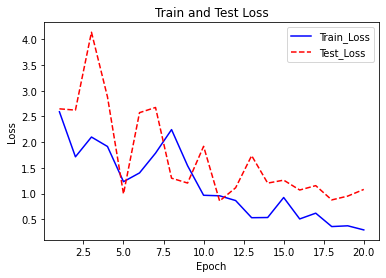

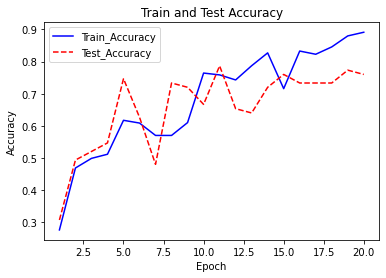

In [19]:
#train test それぞれの損失、正解率のグラフ
# 損失
plt.figure()
plt.title('Train and Test Loss')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Loss')  # 縦軸名
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')  # Test_lossのプロット
plt.legend()  # 凡例

# 正解率
plt.figure()
plt.title('Train and Test Accuracy')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Accuracy')  # 縦軸名
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')  # Test_lossのプロット
plt.legend()

# 表示
plt.show()

In [20]:
save_path = "./2021_8_8_resnet101_84.pth"
torch.save(net.state_dict(),save_path)

In [37]:
# クラスごとの誤分類の数と元のデータ数を表示する
print("訓練データセットの誤分類")

for i in range(7):
    DIR_train = './yukisan/'+ str(i)
    wrong_count_train = wrong_labels_list_train.count(i)
    file_count_train = sum(os.path.isfile(os.path.join(DIR_train,  name)) for name in os.listdir(DIR_train)) * (1-test_size)
    p_train = wrong_count_train*100 / file_count_train
    print("class{}は{}個　 割合は{:.1f}%  データ数 {:.1f}個"
          .format(i, wrong_count_train, p_train, file_count_train))

print("--------------------------------------")
    
print("テストデータセットの誤分類")

for i in range(7):
    DIR_val = './yukisan/'+ str(i)
    wrong_count_val = wrong_labels_list_val.count(i)
    file_count_val = sum(os.path.isfile(os.path.join(DIR_val,  name)) for name in os.listdir(DIR_val)) * test_size
    p_val = wrong_count_val*100 / file_count_val
    print("class{}は{}個 　割合は{:.1f}%  全体データ数 {:.1f}個 "
          .format(i, wrong_count_val, p_val, file_count_val))
    

訓練データセットの誤分類
class0は3個　 割合は8.2%  データ数 36.4個
class1は1個　 割合は6.5%  データ数 15.4個
class2は2個　 割合は6.2%  データ数 32.2個
class3は6個　 割合は23.2%  データ数 25.9個
class4は3個　 割合は35.7%  データ数 8.4個
class5は4個　 割合は15.4%  データ数 25.9個
class6は0個　 割合は0.0%  データ数 33.6個
--------------------------------------
テストデータセットの誤分類
class0は2個 　割合は12.8%  全体データ数 15.6個 
class1は2個 　割合は30.3%  全体データ数 6.6個 
class2は0個 　割合は0.0%  全体データ数 13.8個 
class3は7個 　割合は63.1%  全体データ数 11.1個 
class4は2個 　割合は55.6%  全体データ数 3.6個 
class5は1個 　割合は9.0%  全体データ数 11.1個 
class6は4個 　割合は27.8%  全体データ数 14.4個 


In [38]:
#データフレームにするリスト達の個数が同じか確認する
print("train 誤分類した画像の予測ラベル、正解ラベル、pathのリストの要素の個数の確認")
print(len(wrong_pred_label_list_train), len(wrong_labels_list_train), len(wrong_path_list_train))

print("val　誤分類した画像の予測ラベル、正解ラベル、pathのリストの要素の個数の確認")
print(len(wrong_pred_label_list_val), len(wrong_labels_list_val), len(wrong_path_list_val))


train 誤分類した画像の予測ラベル、正解ラベル、pathのリストの要素の個数の確認
19 19 19
val　誤分類した画像の予測ラベル、正解ラベル、pathのリストの要素の個数の確認
18 18 18


In [39]:
import pandas as pd

#データフレームで誤分類した画像の予測ラベル、正解ラベル、画像のパスを表示する
train_label_dict = {"予想ラベル": wrong_pred_label_list_train, "正解ラベル": wrong_labels_list_train,
                   "path": wrong_path_list_train}
train_label_df = pd.DataFrame.from_dict(train_label_dict)

val_label_dict = {"予想ラベル": wrong_pred_label_list_val, "正解ラベル": wrong_labels_list_val,
                 "path": wrong_path_list_val}
val_label_df = pd.DataFrame.from_dict(val_label_dict)

In [40]:
print("訓練セットの予測ミス")
df_train_s = train_label_df.sort_values('予想ラベル').reset_index(drop=True)
df_train_s

訓練セットの予測ミス


,予想ラベル,正解ラベル,path
0,0,1,./yukisan\1\seq61.png
1,0,2,./yukisan\2\seq251.png
2,0,5,./yukisan\5\seq83.png
3,0,5,./yukisan\5\seq99.png
4,1,0,./yukisan\0\seq5.png
5,1,0,./yukisan\0\seq6.png
6,2,4,./yukisan\4\seq76.png
7,2,3,./yukisan\3\seq178.png
8,2,3,./yukisan\3\seq238.png
9,2,3,./yukisan\3\seq229.png


In [41]:
print("テストセットの予測ミス")
val_label_df
val_label_df_s = val_label_df.sort_values('予想ラベル').reset_index(drop=True)
val_label_df_s

テストセットの予測ミス


,予想ラベル,正解ラベル,path
0,0,1,./yukisan\1\seq62.png
1,0,1,./yukisan\1\seq63.png
2,1,0,./yukisan\0\seq18.png
3,1,0,./yukisan\0\seq15.png
4,2,3,./yukisan\3\seq166.png
5,2,3,./yukisan\3\seq201.png
6,2,3,./yukisan\3\seq187.png
7,2,3,./yukisan\3\seq183.png
8,2,3,./yukisan\3\seq208.png
9,2,3,./yukisan\3\seq224.png


In [26]:
def wrong_review(phase="train", index=0):
    """
    分類ミスした画像を表示する関数
    Parameters
    ------------------
    phase: "train" or "val" 
    index: int
        確認したい画像のインデックス
    
    Return
    ------------------
        指定した画像を表示
    
    """
    if phase == "train":
            path = train_label_df.iloc[index, 2]
            img = Image.open(path).convert('RGB')
            plt.imshow(img)
            print(("予測ラベル:{}  正解ラベル:{}".format(train_label_df.iloc[index, 0], train_label_df.iloc[index, 1])))
            plt.show()
            
    elif phase == "val":
            path = val_label_df.iloc[index, 2]
            img = Image.open(path).convert('RGB')
            plt.imshow(img)
            print(("予測ラベル:{}  正解ラベル:{}".format(val_label_df.iloc[index, 0], val_label_df.iloc[index, 1])))
            plt.show() 
            
    

予測ラベル:2  正解ラベル3


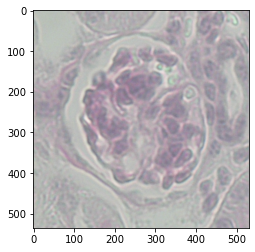

In [27]:
wrong_review("val", 9)

In [45]:
concat_df = pd.concat([df_train_s, val_label_df_s])
concat_df

,予想ラベル,正解ラベル,path
0,0,1,./yukisan\1\seq61.png
1,0,2,./yukisan\2\seq251.png
2,0,5,./yukisan\5\seq83.png
3,0,5,./yukisan\5\seq99.png
4,1,0,./yukisan\0\seq5.png
5,1,0,./yukisan\0\seq6.png
6,2,4,./yukisan\4\seq76.png
7,2,3,./yukisan\3\seq178.png
8,2,3,./yukisan\3\seq238.png
9,2,3,./yukisan\3\seq229.png


In [46]:
concat_df_s = concat_df.sort_values("予想ラベル").reset_index(drop=True)

In [47]:
concat_df_s

,予想ラベル,正解ラベル,path
0,0,1,./yukisan\1\seq61.png
1,0,2,./yukisan\2\seq251.png
2,0,5,./yukisan\5\seq83.png
3,0,5,./yukisan\5\seq99.png
4,0,1,./yukisan\1\seq62.png
5,0,1,./yukisan\1\seq63.png
6,1,0,./yukisan\0\seq15.png
7,1,0,./yukisan\0\seq18.png
8,1,0,./yukisan\0\seq6.png
9,1,0,./yukisan\0\seq5.png
